# Multiclass classification

In this notebook I will analyze how Similarity Forest performs the multiclass classification task and compare different approaches for doing so. I will also compare the results with Random Forest's results.

The Wine dataset comes from UCI Machine Learning Repository. It consists of 178 observations described by 13 features. There are 6 classes present.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from simforest import SimilarityForestClassifier, SimilarityTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.classifier import ClassificationReport, class_prediction_error
from yellowbrick.target import ClassBalance
from simforest.utils import plot_model_selection, plot_confusion_matrix
from yellowbrick.classifier.rocauc import roc_auc

%matplotlib inline
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('examples/data/dataset_glass.csv')
df = df.sample(frac=1, random_state=42)

I'm splitting the data randomly, encode the labels and scale the features.

In [3]:
y, X = df.pop('Type'), df
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

After necessary preprocessing, I plot the class distribution - there are two most popular, and four less common classes.

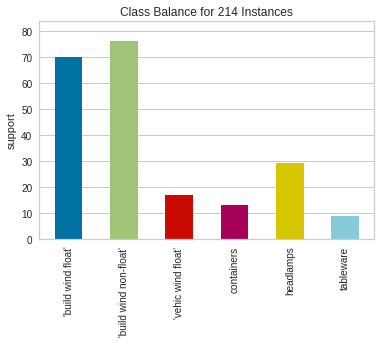

In [4]:
class_visualizer = ClassBalance()

class_visualizer.fit(y)
plt.xticks(rotation=90)
class_visualizer.show();

Similarity Forest classification report

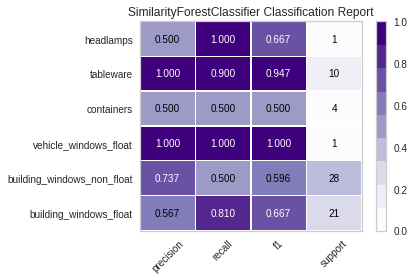

In [5]:
classes = ['building_windows_float', 'building_windows_non_float', 'vehicle_windows_float',
           'containers', 'tableware', 'headlamps']

sf = SimilarityForestClassifier(n_estimators=100, random_state=42)
sf_visualizer = ClassificationReport(sf, classes=classes, support=True, cmap='Purples')

sf_visualizer.fit(X_train, y_train)
sf_visualizer.score(X_test, y_test)
sf_visualizer.show();

Similarity Forest confusion matrix

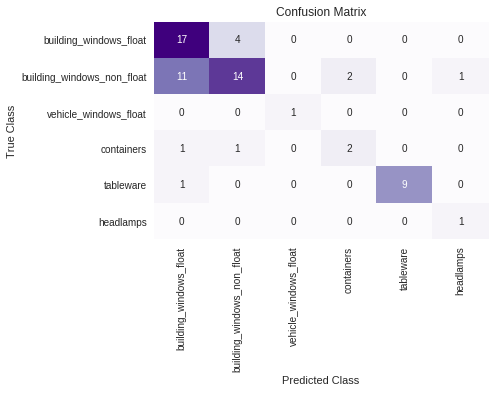

In [6]:
plot_confusion_matrix(sf_visualizer, X_test, y_test, classes=classes, cmap='Purples')

Random Forest classification report

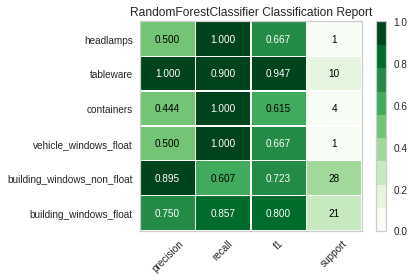

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_visualizer = ClassificationReport(rf, classes=classes, support=True, cmap='Greens')

rf_visualizer.fit(X_train, y_train)
rf_visualizer.score(X_test, y_test)
rf_visualizer.show();

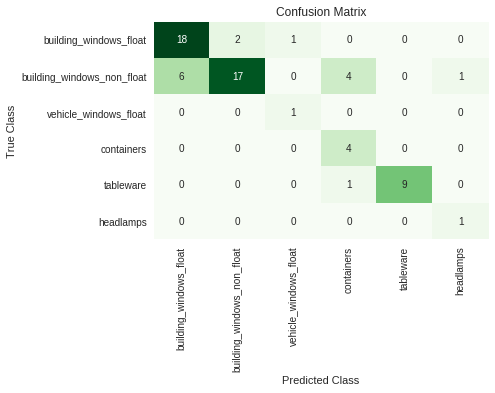

In [8]:
plot_confusion_matrix(rf_visualizer, X_test, y_test, classes=classes, cmap='Greens')

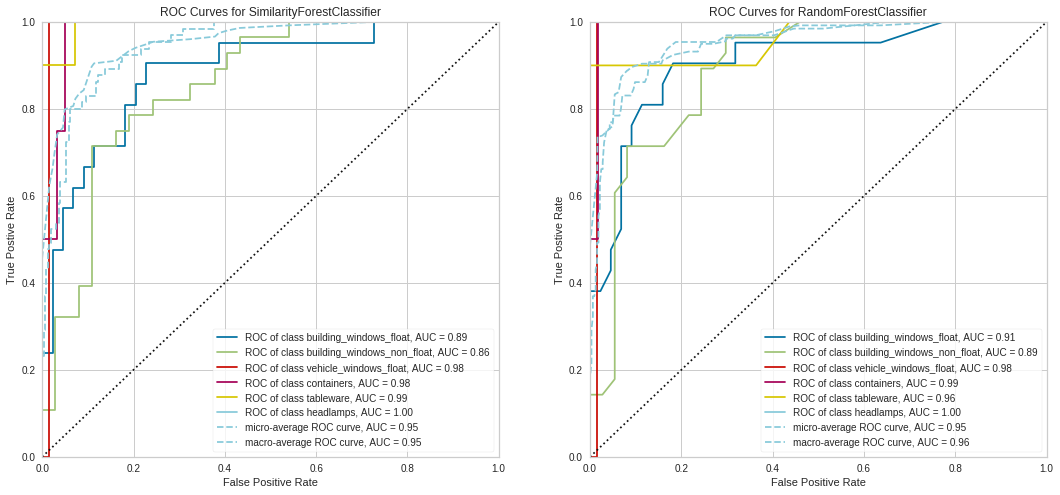

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
roc_auc(sf, X_train, y_train, X_test, y_test, classes=classes, ax=ax[0], show=False);
roc_auc(rf, X_train, y_train, X_test, y_test, classes=classes, ax=ax[1], show=False);
plt.show()

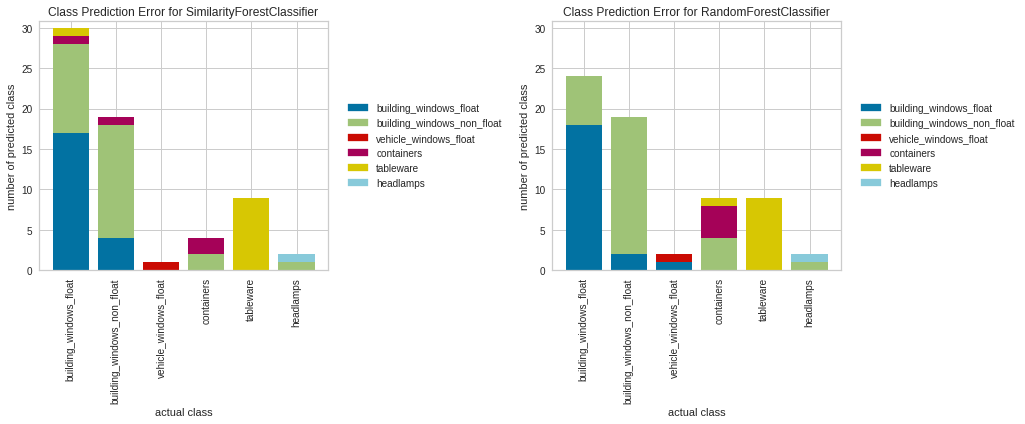

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
class_prediction_error(sf, X_train, y_train, X_test, y_test, classes=classes, ax=ax[0], show=False);
class_prediction_error(rf, X_train, y_train, X_test, y_test, classes=classes, ax=ax[1], show=False);
plt.show()

# Model selection

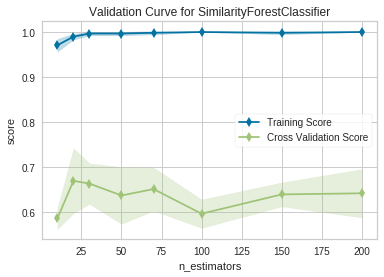

In [11]:
sf_visualizer = ValidationCurve(
    SimilarityForestClassifier(), param_name='n_estimators',
    param_range=[10, 20, 30, 50, 70, 100, 150, 200], cv=5, scoring='f1_weighted'
)

sf_visualizer.fit(X_train, y_train)
sf_visualizer.show();

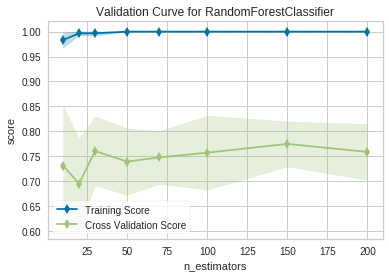

In [12]:
rf_visualizer = ValidationCurve(
    RandomForestClassifier(), param_name='n_estimators',
    param_range=[10, 20, 30, 50, 70, 100, 150, 200], cv=5, scoring='f1_weighted'
)

rf_visualizer.fit(X_train, y_train)
rf_visualizer.show();

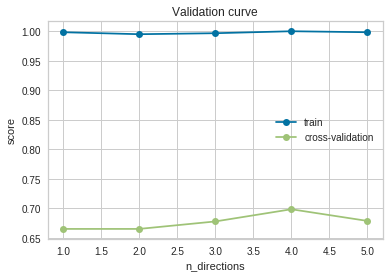

In [13]:
_ = plot_model_selection(SimilarityForestClassifier(n_estimators=30), 'n_directions', [1, 2, 3, 4, 5], X_train, y_train)

# Learning curve

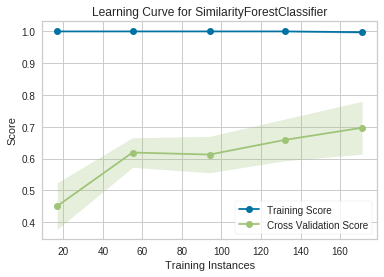

In [14]:
cv = StratifiedKFold(n_splits=5)

sf = SimilarityForestClassifier(n_estimators=100)
sf_visualizer = LearningCurve(sf, cv=cv, scoring='f1_weighted', n_jobs=4)

sf_visualizer.fit(X, y)
sf_visualizer.show();

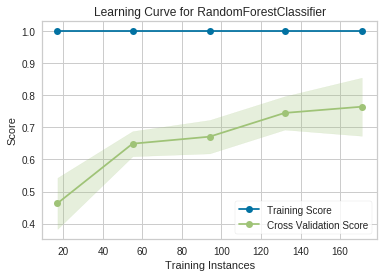

In [15]:
cv = StratifiedKFold(n_splits=5)

rf = RandomForestClassifier()
rf_visualizer = LearningCurve(rf, cv=cv, scoring='f1_weighted', n_jobs=4)

rf_visualizer.fit(X, y)
rf_visualizer.show();

# Single trees

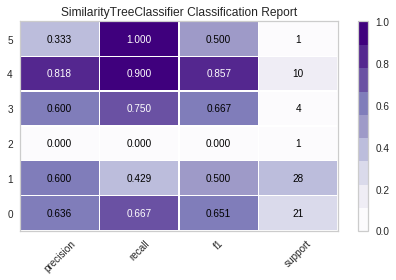

In [16]:
st = SimilarityTreeClassifier(random_state=42)
st_visualizer = ClassificationReport(st, support=True, cmap='Purples')

st_visualizer.fit(X_train, y_train)
st_visualizer.score(X_test, y_test)
st_visualizer.show();

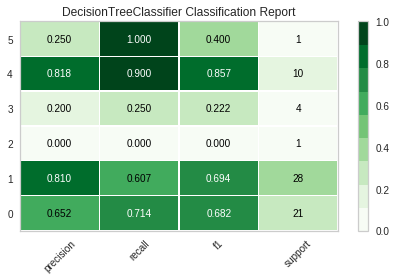

In [17]:
dt = DecisionTreeClassifier(random_state=42)
dt_visualizer = ClassificationReport(dt, support=True, cmap='Greens')

dt_visualizer.fit(X_train, y_train)
dt_visualizer.score(X_test, y_test)
dt_visualizer.show();

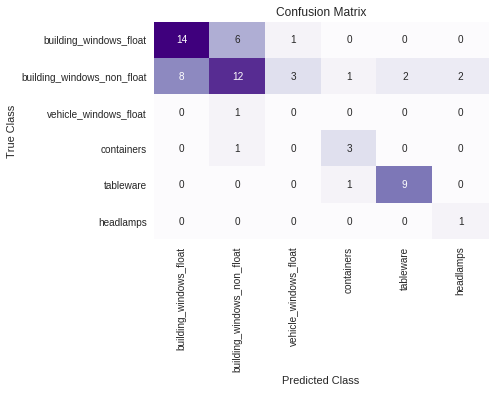

In [18]:
plot_confusion_matrix(st_visualizer, X_test, y_test, classes=classes, cmap='Purples')

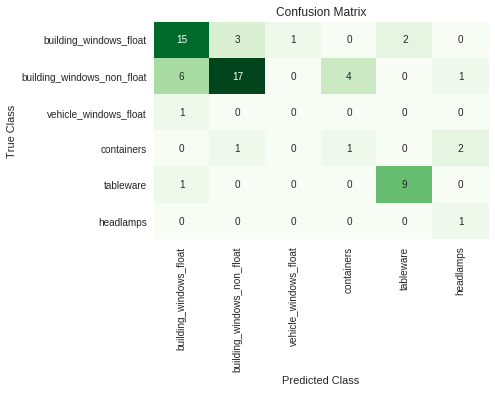

In [19]:
plot_confusion_matrix(dt_visualizer, X_test, y_test, classes=classes, cmap='Greens')

ROC curves for the trees

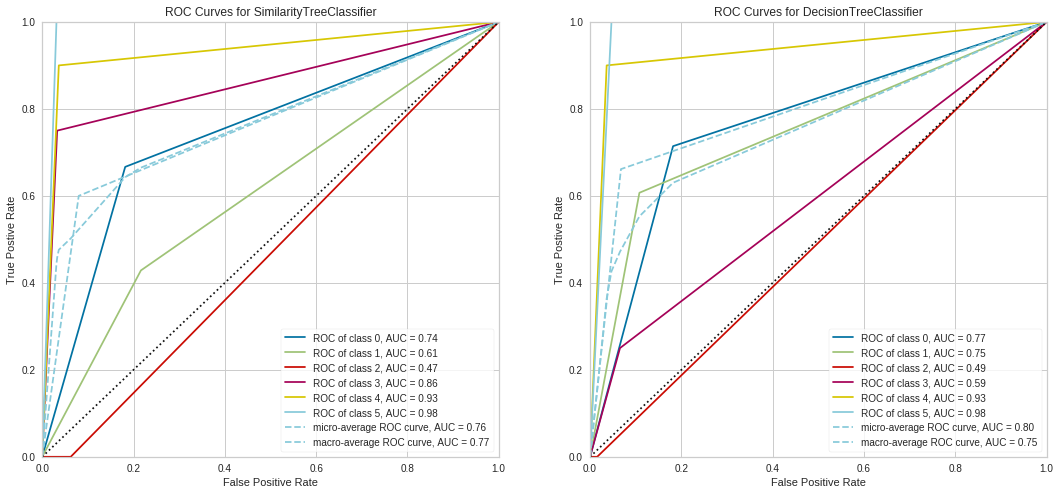

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
roc_auc(st, X_train, y_train, X_test, y_test, ax=ax[0], show=False);
roc_auc(dt, X_train, y_train, X_test, y_test, ax=ax[1], show=False);
plt.show()

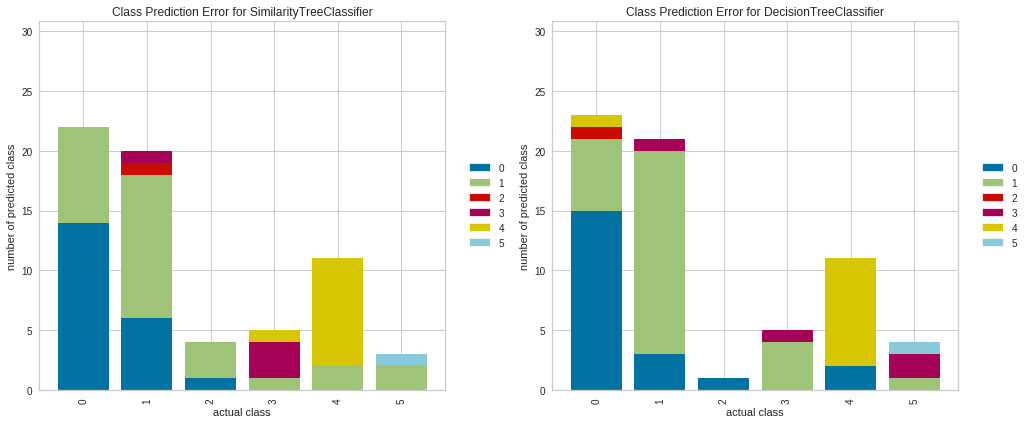

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
class_prediction_error(st, X_train, y_train, X_test, y_test, ax=ax[0], show=False);
class_prediction_error(dt, X_train, y_train, X_test, y_test, ax=ax[1], show=False);
plt.show()

# Single tree model selection

We can observe that shallow Similarity Tree underfits the data much more than Decision Tree.

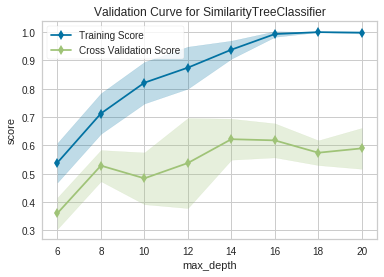

In [22]:
st_visualizer = ValidationCurve(
    SimilarityTreeClassifier(), param_name='max_depth',
    param_range=[6, 8, 10, 12, 14, 16, 18, 20], cv=5, scoring='f1_weighted'
)

st_visualizer.fit(X_train, y_train)
st_visualizer.show();

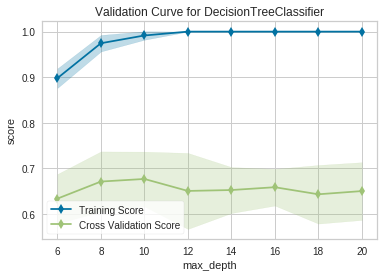

In [23]:
dt_visualizer = ValidationCurve(
    DecisionTreeClassifier(), param_name='max_depth',
    param_range=[6, 8, 10, 12, 14, 16, 18, 20], cv=5, scoring='f1_weighted'
)

dt_visualizer.fit(X_train, y_train)
dt_visualizer.show();

Choosing number of split directions for a single tree

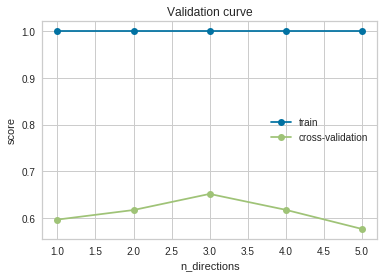

In [24]:
_ = plot_model_selection(SimilarityTreeClassifier(), 'n_directions', [1, 2, 3, 4, 5], X_train, y_train)

# Single tree learning curve

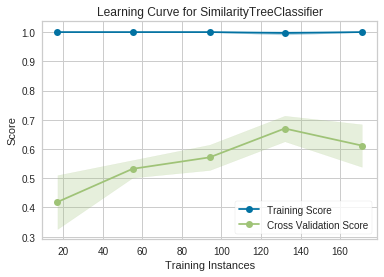

In [25]:
cv = StratifiedKFold(n_splits=5)

st = SimilarityTreeClassifier()
st_visualizer = LearningCurve(st, cv=cv, scoring='f1_weighted', n_jobs=4)

st_visualizer.fit(X, y)
st_visualizer.show();

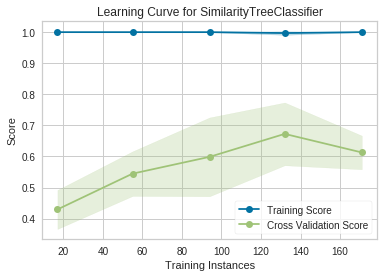

In [26]:
cv = StratifiedKFold(n_splits=5)

dt = SimilarityTreeClassifier()
dt_visualizer = LearningCurve(dt, cv=cv, scoring='f1_weighted', n_jobs=4)

dt_visualizer.fit(X, y)
dt_visualizer.show();

# Different multiclass strategies

Apart from simple multiclass strategy for Similarity Forest, in which a single classifier is build to differentiate between all classes, there are also other strategies that transform the multiclass problems into several binary problems.

These strategies include:
- One vs Rest, in which a classifier learns to differentiate between one of the classes and all other classes
- One vs One, in which a classifier learns to differentiate between all pairs of classes
- Error Correcting Output Codes - each class is represented by a binary code of some given length, and the classifiers learn co classify particular bit in the code. In prediction phase, an object is labeled with a class whose code is closest to its code prediction

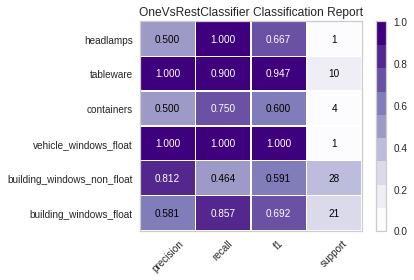

In [27]:
o_vs_r = OneVsRestClassifier(SimilarityForestClassifier(n_estimators=100, random_state=42))
o_vs_r_visualizer = ClassificationReport(o_vs_r, classes=classes, support=True, cmap='Purples')

o_vs_r_visualizer.fit(X_train, y_train)
o_vs_r_visualizer.score(X_test, y_test)
o_vs_r_visualizer.show();

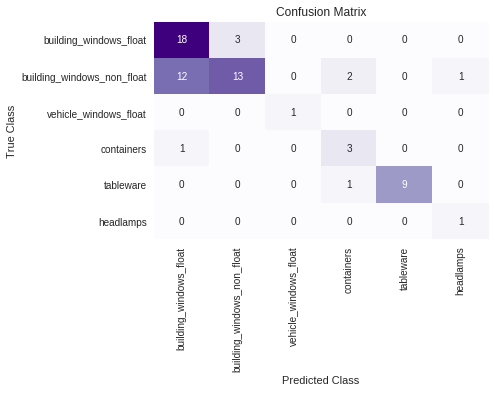

In [28]:
plot_confusion_matrix(o_vs_r_visualizer, X_test, y_test, classes=classes, cmap='Purples')

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


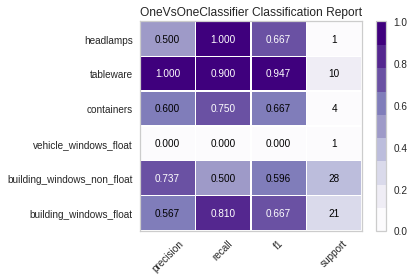

In [29]:
o_vs_o = OneVsOneClassifier(SimilarityForestClassifier(n_estimators=100, random_state=42))
o_vs_o_visualizer = ClassificationReport(o_vs_o, classes=classes, support=True, cmap='Purples')

o_vs_o_visualizer.fit(X_train, y_train)
o_vs_o_visualizer.score(X_test, y_test)
o_vs_o_visualizer.show();

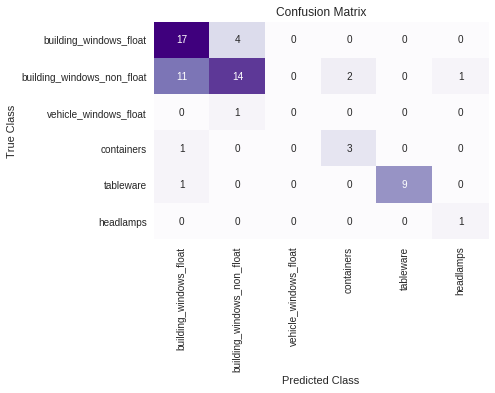

In [30]:
plot_confusion_matrix(o_vs_o_visualizer, X_test, y_test, classes=classes, cmap='Purples')

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


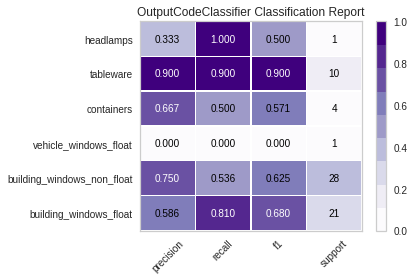

In [31]:
ooc_sf = OutputCodeClassifier(SimilarityForestClassifier(n_estimators=100, random_state=42))
ooc_sf_visualizer = ClassificationReport(ooc_sf, classes=classes, support=True, cmap='Purples')

ooc_sf_visualizer.fit(X_train, y_train)
ooc_sf_visualizer.score(X_test, y_test)
ooc_sf_visualizer.show();

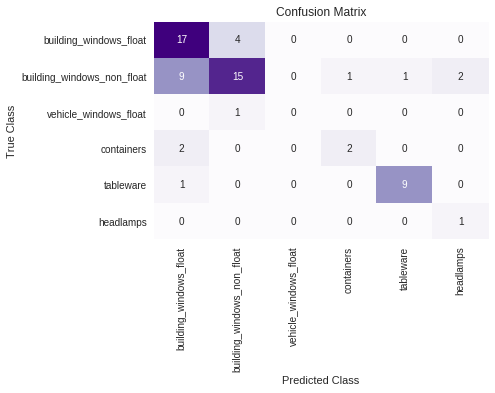

In [32]:
plot_confusion_matrix(ooc_sf_visualizer, X_test, y_test, classes=classes, cmap='Purples')

# Multiclass strategies comparision

In case of this dataset, the simple multiclass strategy adn OneVSRest work best. We can analize futher how their performance compare.

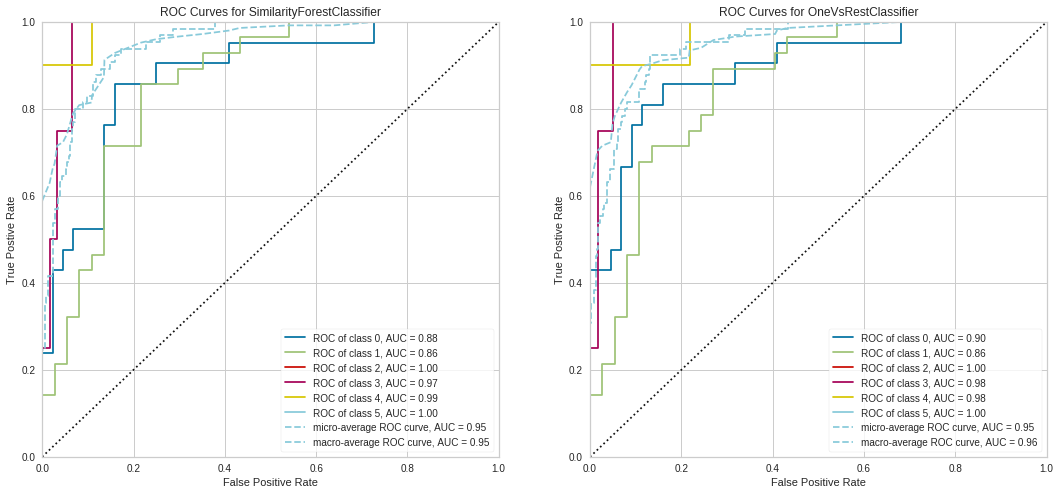

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
roc_auc(sf, X_train, y_train, X_test, y_test, ax=ax[0], show=False);
roc_auc(o_vs_r, X_train, y_train, X_test, y_test, ax=ax[1], show=False);
plt.show()

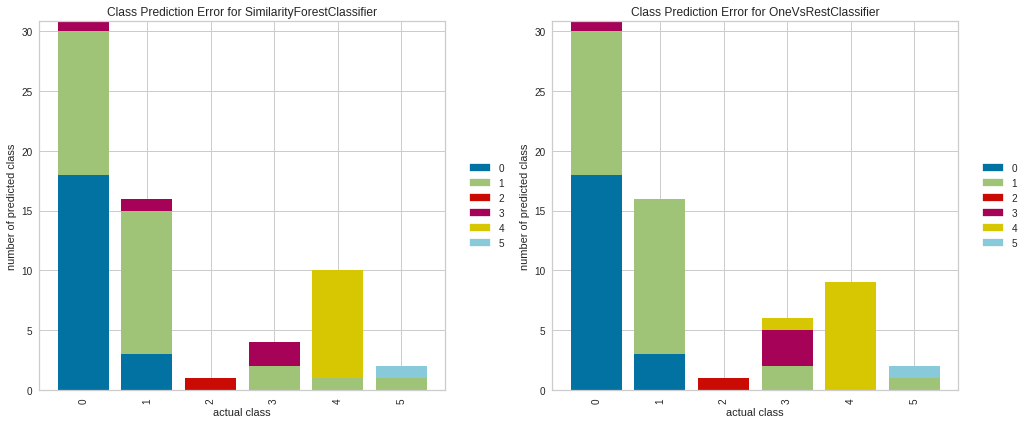

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
class_prediction_error(sf, X_train, y_train, X_test, y_test, ax=ax[0], show=False);
class_prediction_error(o_vs_r, X_train, y_train, X_test, y_test, ax=ax[1], show=False);
plt.show()